In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

# Hugging Face tokenizer (BERT tokenizer is used, not the full BERT model for embeddings here)
from transformers import BertTokenizerFast

# Scikit-learn for splitting and label encoding
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial
import os
import requests
import zipfile
import re

In [3]:
# --- GloVe Configuration ---
GLOVE_FILE_NAME = 'glove.6B.300d.txt' # Using 300-dimensional GloVe embeddings
GLOVE_EMBEDDING_DIM = 300
GLOVE_PATH = f'./{GLOVE_FILE_NAME}'
GLOVE_ZIP_URL = 'http://nlp.stanford.edu/data/glove.6B.zip'
GLOVE_LOCAL_ZIP_PATH = './glove.6B.zip'

# --- Model & Training Configuration ---
# NUM_CLS will be set dynamically based on the dataset
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 32 # Adjusted from 64, might need tuning
LEARNING_RATE = 0.001 # Adjusted, common starting point for Adam/SGD with momentum
WEIGHT_DECAY = 1e-4
NUM_EPOCHS = 10 # Adjust as needed based on convergence
VALID_SET_SIZE = 0.2 # Proportion of the dataset to use for validation if not using a pre-defined test set
MIN_CLASS_REPRESENTATION = 2 # Minimum samples for a class to be considered for stratified split


In [4]:
# --- GloVe File Handling ---
def ensure_glove_file_is_present():
    if os.path.exists(GLOVE_PATH):
        print(f"Found existing GloVe text file: {GLOVE_PATH}")
        return True
    if not os.path.exists(GLOVE_LOCAL_ZIP_PATH):
        print(f"GloVe zip file {GLOVE_LOCAL_ZIP_PATH} not found. Attempting to download from {GLOVE_ZIP_URL}...")
        try:
            response = requests.get(GLOVE_ZIP_URL, stream=True)
            response.raise_for_status()
            total_size_in_bytes = int(response.headers.get('content-length', 0))
            block_size = 1024
            with open(GLOVE_LOCAL_ZIP_PATH, 'wb') as file, tqdm(
                desc=f"Downloading {os.path.basename(GLOVE_ZIP_URL)}",
                total=total_size_in_bytes, unit='iB', unit_scale=True, unit_divisor=1024,
            ) as bar:
                for data in response.iter_content(block_size):
                    bar.update(len(data))
                    file.write(data)
            print(f"Successfully downloaded {GLOVE_LOCAL_ZIP_PATH}")
        except requests.exceptions.RequestException as e:
            print(f"Error downloading GloVe zip file: {e}")
            if os.path.exists(GLOVE_LOCAL_ZIP_PATH): os.remove(GLOVE_LOCAL_ZIP_PATH)
            return False
        except Exception as e:
            print(f"An unexpected error occurred during download: {e}")
            if os.path.exists(GLOVE_LOCAL_ZIP_PATH): os.remove(GLOVE_LOCAL_ZIP_PATH)
            return False
    else:
        print(f"Found existing GloVe zip file: {GLOVE_LOCAL_ZIP_PATH}")

    print(f"Attempting to extract {GLOVE_FILE_NAME} from {GLOVE_LOCAL_ZIP_PATH}...")
    try:
        with zipfile.ZipFile(GLOVE_LOCAL_ZIP_PATH, 'r') as zip_ref:
            if GLOVE_FILE_NAME in zip_ref.namelist():
                zip_ref.extract(GLOVE_FILE_NAME, path=os.path.dirname(GLOVE_PATH) or '.')
                print(f"Successfully extracted {GLOVE_FILE_NAME} to {GLOVE_PATH}")
                return True
            else:
                print(f"Error: {GLOVE_FILE_NAME} not found inside {GLOVE_LOCAL_ZIP_PATH}.")
                print(f"Available files: {zip_ref.namelist()}")
                return False
    except zipfile.BadZipFile:
        print(f"Error: {GLOVE_LOCAL_ZIP_PATH} is a bad zip file. Please delete it and try again.")
        return False
    except Exception as e:
        print(f"An error occurred during extraction: {e}")
        return False

if not ensure_glove_file_is_present():
    print("Could not obtain GloVe file. Exiting.")
    exit()

def load_glove_vectors(glove_path, embedding_dim):
    print(f"Loading GloVe vectors from {glove_path} with dimension {embedding_dim}...")
    if not os.path.exists(glove_path):
        print(f"Error: GloVe file not found at {glove_path}.")
        return None
    word_to_vec = {}
    try:
        with open(glove_path, 'r', encoding='utf-8') as f:
            for line in tqdm(f, desc="Loading GloVe"):
                values = line.split()
                word = values[0]
                try:
                    vector = np.asarray(values[1:], dtype='float32')
                    if len(vector) == embedding_dim:
                        word_to_vec[word] = vector
                except ValueError:
                    pass
    except Exception as e:
        print(f"An error occurred while reading the GloVe file: {e}")
        return None
    if not word_to_vec:
        print(f"No word vectors loaded from {glove_path}.")
        return None
    print(f"Successfully loaded {len(word_to_vec)} word vectors.")
    return word_to_vec

glove_vectors_map = load_glove_vectors(GLOVE_PATH, GLOVE_EMBEDDING_DIM)

unk_embedding = np.random.rand(GLOVE_EMBEDDING_DIM).astype('float32') # Random UNK if not in GloVe
if glove_vectors_map:
    if '[unk]' in glove_vectors_map: unk_embedding = glove_vectors_map['[unk]']
    elif 'unk' in glove_vectors_map: unk_embedding = glove_vectors_map['unk']
else:
    print("GloVe vectors map is empty or not loaded. Using random UNK embedding. Training will be affected.")
    # exit() # Critical error, might be best to exit


Found existing GloVe text file: ./glove.6B.300d.txt
Loading GloVe vectors from ./glove.6B.300d.txt with dimension 300...


Loading GloVe: 400000it [00:13, 28709.09it/s]

Successfully loaded 400000 word vectors.


In [5]:

# --- Load Tokenizer (Hugging Face) ---
print("Loading BERT tokenizer...")
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
print("Tokenizer loaded.")



Loading BERT tokenizer...
Tokenizer loaded.


In [6]:
# --- Load and Prepare gcc_data.csv ---
print("Loading gcc_data.csv...")
try:
    df = pd.read_csv('../datasets/gcc_data.csv')
except FileNotFoundError:
    print("Error: gcc_data.csv not found. Please place it in the script's directory or provide the full path.")
    exit()

print(f"Original gcc_data shape: {df.shape}")

# Basic preprocessing for text columns
df['Summary'] = df['Summary'].fillna('').astype(str)
df['Description'] = df['Description'].fillna('').astype(str)
df['text_input'] = df['Summary'] + " " + df['Description']

# Target variable: Assignee. Drop rows with missing Assignee.
df.dropna(subset=['Assignee'], inplace=True)
df['Assignee'] = df['Assignee'].astype(str) # Ensure assignee names are strings
print(f"Shape after dropping NA assignees: {df.shape}")

# Label Encoding for Assignee
assignee_encoder = LabelEncoder()
df['assignee_encoded'] = assignee_encoder.fit_transform(df['Assignee'])
NUM_ACTUAL_CLS = len(assignee_encoder.classes_)
print(f"Number of unique assignees (classes): {NUM_ACTUAL_CLS}")
if NUM_ACTUAL_CLS <= 1:
    print("Error: Only one or no classes found after encoding. Cannot train classifier.")
    exit()



Loading gcc_data.csv...
Original gcc_data shape: (2103, 5)
Shape after dropping NA assignees: (2103, 6)
Number of unique assignees (classes): 82


In [7]:
# --- Train/Test Split ---
texts = df['text_input'].tolist()
labels = df['assignee_encoded'].tolist() # Use encoded labels

# Stratify only if all classes have at least MIN_CLASS_REPRESENTATION samples
assignee_counts = df['Assignee'].value_counts()
small_classes = assignee_counts[assignee_counts < MIN_CLASS_REPRESENTATION].index.tolist()

stratify_labels = None
if not small_classes: # If all classes have enough samples
    stratify_labels = labels
    print(f"Attempting stratified split. All {NUM_ACTUAL_CLS} classes have at least {MIN_CLASS_REPRESENTATION} samples.")
else:
    print(f"Warning: {len(small_classes)} classes have fewer than {MIN_CLASS_REPRESENTATION} samples. Proceeding without stratification.")
    print(f"Small classes: {small_classes[:5]}...") # Print a few small classes


train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=VALID_SET_SIZE, random_state=42, shuffle=True, stratify=stratify_labels
)

print(f"Train set size: {len(train_texts)}, Test set size: {len(test_texts)}")



Small classes: ['Bill Schmidt', 'Martin Liška', 'Segher Boessenkool', 'Andreas Schwab', 'Richard Earnshaw']...
Train set size: 1682, Test set size: 421


In [8]:
# --- Prepare data for DataLoader (list of dicts) ---
def create_data_list(texts, labels):
    return [{'text': text, 'label': label} for text, label in zip(texts, labels)]

train_data_list = create_data_list(train_texts, train_labels)
test_data_list = create_data_list(test_texts, test_labels)




In [9]:
# --- Collate Function (adapted for custom data) ---
def collate_with_glove(batch, hf_tokenizer, glove_word_vectors, embedding_dimension, unk_word_embedding):
    labels_list = [item['label'] for item in batch]
    texts_list = [item['text'] for item in batch]
    
    # Ensure labels are LongTensors for CrossEntropyLoss
    labels = torch.LongTensor(labels_list) 

    all_sequences_as_vecs = []
    for text_item in texts_list:
        string_tokens = hf_tokenizer.tokenize(str(text_item)) # Ensure text_item is string

        if not string_tokens:
            all_sequences_as_vecs.append(torch.tensor(unk_word_embedding, dtype=torch.float).unsqueeze(0))
            continue

        current_sequence_embeddings = []
        for token_str in string_tokens:
            vec = glove_word_vectors.get(token_str, unk_word_embedding)
            current_sequence_embeddings.append(torch.tensor(vec, dtype=torch.float))
        
        if not current_sequence_embeddings:
            all_sequences_as_vecs.append(torch.tensor(unk_word_embedding, dtype=torch.float).unsqueeze(0))
        else:
            all_sequences_as_vecs.append(torch.stack(current_sequence_embeddings))

    vecs_padded = pad_sequence(all_sequences_as_vecs, batch_first=False, padding_value=0.0)
    return vecs_padded, labels



In [10]:
# --- Create DataLoaders ---
if glove_vectors_map is not None and train_data_list and test_data_list:
    collate_fn_custom = partial(collate_with_glove,
                                 hf_tokenizer=tokenizer,
                                 glove_word_vectors=glove_vectors_map,
                                 embedding_dimension=GLOVE_EMBEDDING_DIM,
                                 unk_word_embedding=unk_embedding)

    train_loader = DataLoader(train_data_list, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_custom)
    test_loader = DataLoader(test_data_list, batch_size=BATCH_SIZE, collate_fn=collate_fn_custom)
    print("DataLoaders created for gcc_data.")
else:
    print("GloVe vectors not loaded or data lists are empty. Cannot create DataLoaders.")
    train_loader = None
    test_loader = None



DataLoaders created for gcc_data.


In [11]:
# --- Utility Classes and CNN Model (largely unchanged) ---
class AverageMeter(object):
    def __init__(self): self.reset()
    def reset(self): self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
    def update(self, val, n=1):
        self.val = val; self.sum += val * n; self.count += n; self.avg = self.sum / self.count

class CNNModel(nn.Module):
    def __init__(self, embed_dim, filter_sizes, num_filters_per_size, num_classes, dropout_rate):
        super(CNNModel, self).__init__()
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=embed_dim, out_channels=n_filters, kernel_size=f_size)
            for f_size, n_filters in zip(filter_sizes, num_filters_per_size) # Iterate over pairs
        ])
        # Calculate total number of filters correctly
        total_filters = sum(num_filters_per_size)
        self.fc = nn.Linear(total_filters, num_classes)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        # x shape: (max_seq_length, batch_size, embedding_dim)
        x = x.permute(1, 2, 0) # (batch_size, embedding_dim, max_seq_length)

        conv_outputs = []
        for conv_layer in self.conv1d_list:
            conv_output = conv_layer(x)
            conv_output = F.relu(conv_output)
            conv_output = F.max_pool1d(conv_output, kernel_size=conv_output.size(2)).squeeze(2)
            conv_outputs.append(conv_output)

        x_concatenated = torch.cat(conv_outputs, dim=1)
        x_dropped_out = self.dropout(x_concatenated)
        logits = self.fc(x_dropped_out)
        return logits



In [12]:
# --- Training and Validation Functions (largely unchanged) ---
def train_one_epoch(model, dataloader, loss_function, optim, current_epoch=None):
    model.train()
    loss_meter = AverageMeter()
    correct_predictions = 0
    total_samples = 0
    tepoch = tqdm(dataloader, unit="batch")
    if current_epoch is not None: tepoch.set_description(f"Epoch {current_epoch+1}")
    for inputs, targets in tepoch:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        optim.zero_grad(); loss.backward(); optim.step()
        loss_meter.update(loss.item(), inputs.size(1)) # batch_size is second dim of permuted input
        _, predicted_labels = torch.max(outputs.data, 1)
        total_samples += targets.size(0)
        correct_predictions += (predicted_labels == targets).sum().item()
        tepoch.set_postfix(loss=loss_meter.avg, accuracy=100. * correct_predictions / total_samples if total_samples > 0 else 0)
    return model, loss_meter.avg, (100. * correct_predictions / total_samples if total_samples > 0 else 0)

def validate_model(model, dataloader, loss_function):
    model.eval()
    loss_meter = AverageMeter()
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad(), tqdm(dataloader, unit="batch", desc="Validating") as tepoch:
        for inputs, targets in tepoch:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            loss_meter.update(loss.item(), inputs.size(1))
            _, predicted_labels = torch.max(outputs.data, 1)
            total_samples += targets.size(0)
            correct_predictions += (predicted_labels == targets).sum().item()
            tepoch.set_postfix(loss=loss_meter.avg, accuracy=100. * correct_predictions / total_samples if total_samples > 0 else 0)
    return loss_meter.avg, (100. * correct_predictions / total_samples if total_samples > 0 else 0)




Token indices sequence length is longer than the specified maximum sequence length for this model (757 > 512). Running this sequence through the model will result in indexing errors



Using device: cuda

Sample batch - X shape: torch.Size([1835, 32, 300]), Y shape: torch.Size([32])

CNN Model Initialized with 82 output classes.
CNNModel(
  (conv1d_list): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(2,), stride=(1,))
    (1): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (2): Conv1d(300, 100, kernel_size=(4,), stride=(1,))
    (3): Conv1d(300, 100, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=400, out_features=82, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

--- Starting Model Training ---


Validating: 100%|██████████| 14/14 [00:02<00:00,  6.74batch/s, accuracy=33, loss=3.05]  


Model Saved as cnn_bug_assign_best.pt!
Validation: Loss = 3.0520, Accuracy = 33.02%
------------------------------


Validating: 100%|██████████| 14/14 [00:02<00:00,  6.95batch/s, accuracy=40.4, loss=2.61]


Model Saved as cnn_bug_assign_best.pt!
Validation: Loss = 2.6131, Accuracy = 40.38%
------------------------------


Validating: 100%|██████████| 14/14 [00:02<00:00,  6.46batch/s, accuracy=45.1, loss=2.34]


Model Saved as cnn_bug_assign_best.pt!
Validation: Loss = 2.3355, Accuracy = 45.13%
------------------------------


Validating: 100%|██████████| 14/14 [00:02<00:00,  6.58batch/s, accuracy=51.5, loss=2.18]


Model Saved as cnn_bug_assign_best.pt!
Validation: Loss = 2.1805, Accuracy = 51.54%
------------------------------


Validating: 100%|██████████| 14/14 [00:02<00:00,  6.90batch/s, accuracy=50.4, loss=2.04]


Model Saved as cnn_bug_assign_best.pt!
Validation: Loss = 2.0378, Accuracy = 50.36%
------------------------------


Validating: 100%|██████████| 14/14 [00:02<00:00,  6.66batch/s, accuracy=54.6, loss=1.92]


Model Saved as cnn_bug_assign_best.pt!
Validation: Loss = 1.9248, Accuracy = 54.63%
------------------------------


Validating: 100%|██████████| 14/14 [00:02<00:00,  6.55batch/s, accuracy=57, loss=1.85]  


Model Saved as cnn_bug_assign_best.pt!
Validation: Loss = 1.8539, Accuracy = 57.01%
------------------------------


Validating: 100%|██████████| 14/14 [00:02<00:00,  6.83batch/s, accuracy=55.6, loss=1.81]


Model Saved as cnn_bug_assign_best.pt!
Validation: Loss = 1.8088, Accuracy = 55.58%
------------------------------


Validating: 100%|██████████| 14/14 [00:02<00:00,  6.84batch/s, accuracy=57, loss=1.8]   


Model Saved as cnn_bug_assign_best.pt!
Validation: Loss = 1.8005, Accuracy = 57.01%
------------------------------


Validating: 100%|██████████| 14/14 [00:02<00:00,  6.01batch/s, accuracy=56.3, loss=1.79]


Model Saved as cnn_bug_assign_best.pt!
Validation: Loss = 1.7935, Accuracy = 56.29%
------------------------------
--- Training Finished ---


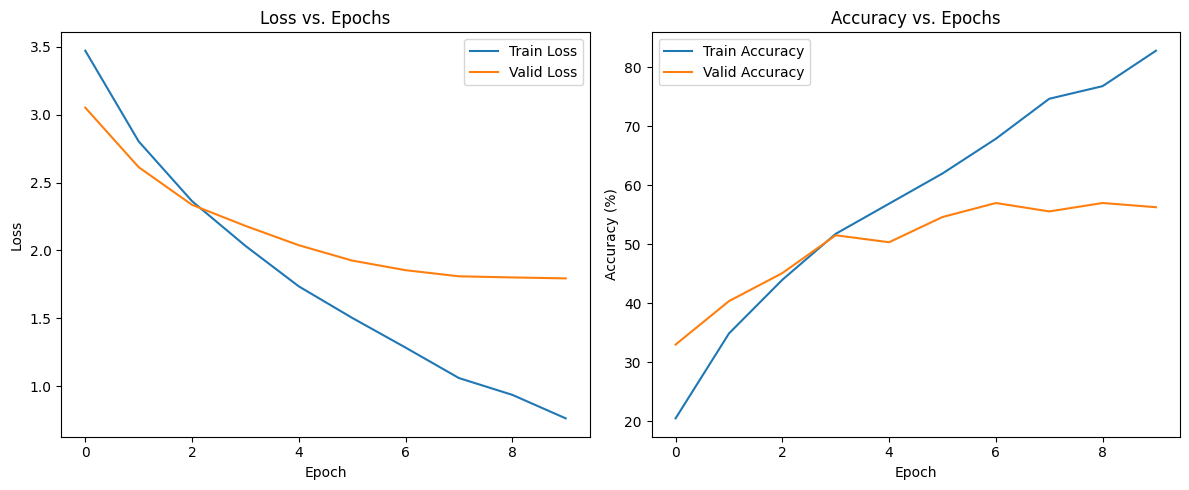


Script execution completed.


In [13]:
# --- Main Training Execution ---
if train_loader and test_loader and NUM_ACTUAL_CLS > 1:
    print(f"\nUsing device: {DEVICE}")
    # Test one batch
    try:
        x_batch, y_batch = next(iter(train_loader))
        print(f"\nSample batch - X shape: {x_batch.shape}, Y shape: {y_batch.shape}")
    except Exception as e:
        print(f"Error getting a batch from train_loader (might be empty or an issue with collate_fn): {e}")
        # exit() # Exit if we can't even get a batch

    # Initialize model, loss, optimizer
    # Ensure num_filters_per_size matches the number of filter_sizes
    filter_kernel_sizes = [2, 3, 4, 5] # Example filter sizes
    num_filters = [100] * len(filter_kernel_sizes) # 100 filters for each size

    cnn_model = CNNModel(embed_dim=GLOVE_EMBEDDING_DIM,
                         filter_sizes=filter_kernel_sizes,
                         num_filters_per_size=num_filters,
                         num_classes=NUM_ACTUAL_CLS, # Use dynamic number of classes
                         dropout_rate=0.5).to(DEVICE)
    print(f"\nCNN Model Initialized with {NUM_ACTUAL_CLS} output classes.")
    print(cnn_model)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    # optimizer = optim.SGD(cnn_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, momentum=0.9)


    history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}
    best_valid_loss = float('inf')

    print("\n--- Starting Model Training ---")
    for epoch_idx in range(NUM_EPOCHS):
        cnn_model, train_loss, train_acc = train_one_epoch(cnn_model, train_loader, criterion, optimizer, epoch_idx)
        valid_loss, valid_acc = validate_model(cnn_model, test_loader, criterion)
        history['train_loss'].append(train_loss); history['valid_loss'].append(valid_loss)
        history['train_acc'].append(train_acc); history['valid_acc'].append(valid_acc)
        if valid_loss < best_valid_loss:
            torch.save(cnn_model.state_dict(), 'cnn_bug_assign_best.pt')
            best_valid_loss = valid_loss
            print('Model Saved as cnn_bug_assign_best.pt!')
        print(f'Validation: Loss = {valid_loss:.4f}, Accuracy = {valid_acc:.2f}%')
        print("-" * 30)
    print("--- Training Finished ---")

    if history['train_loss']:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1); plt.plot(history['train_loss'], label='Train Loss'); plt.plot(history['valid_loss'], label='Valid Loss')
        plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss vs. Epochs')
        plt.subplot(1, 2, 2); plt.plot(history['train_acc'], label='Train Accuracy'); plt.plot(history['valid_acc'], label='Valid Accuracy')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.legend(); plt.title('Accuracy vs. Epochs')
        plt.tight_layout(); plt.show()
else:
    print("Cannot start training: DataLoaders not initialized or insufficient classes.")

print("\nScript execution completed.")